In [1]:
import sys
sys.path.append('./utils/')
import numpy as np
import scipy.io as spio
from scipy.linalg import expm
from matplotlib import pyplot as plt
import sys 
import openfermion as of
import pandas as pd

from analytical_fit import  KiteRelMatrixMany, Get_K2RatesAndOps, Get_K1RatesAndOps, Get_K0RatesAndOps,  get_chemical_shifts, Get_Det_And_Rates, RelMat_from_ops_and_rates
from basis_utils import read_spinach_info, build_list_ISTs, NormalizeBasis, build_symbolic_list_ISTs
from simulation_utils import Hellinger_2D, GenNOESYSpectrum

from analytical_fit import lat_S_plus, lat_S_minus, lat_Sz, J_plus, J_minus,Get_Det_And_Rates_latex

import pickle

# Simple test with DFG

In [2]:
text="""1      (0,0)   (0,0)   
  2      (0,0)   (1,1)   
  3      (0,0)   (1,0)   
  4      (0,0)   (1,-1)  
  5      (1,1)   (0,0)   
  6      (1,1)   (1,1)   
  7      (1,1)   (1,0)   
  8      (1,1)   (1,-1)  
  9      (1,0)   (0,0)   
  10     (1,0)   (1,1)   
  11     (1,0)   (1,0)   
  12     (1,0)   (1,-1)  
  13     (1,-1)  (0,0)   
  14     (1,-1)  (1,1)   
  15     (1,-1)  (1,0)   
  16     (1,-1)  (1,-1)  
"""

data = read_spinach_info(text)

basis = build_list_ISTs(data)
prefacts,Symb_basis = build_symbolic_list_ISTs(data)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=False)
Normbasis = np.array(Normbasis)

In [3]:
gammaF = 251814800
coord1 = np.array([-0.0551,-1.2087,-1.6523])*1e-10
coord2 = np.array([-0.8604 ,-2.3200 ,-0.0624])*1e-10

coords = np.array([coord1,coord2])

w1 = -376417768.6316 
w2 = -376411775.1523 
freqs = np.array([w1,w2])
tc = 0.5255e-9
B0 = 9.3933

zeeman_scalar_1 = -113.8796
zeeman_scalar_2 = -129.8002
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2]

#w0*zeeman_scalars[i]/1e6
chem_shifts = get_chemical_shifts(gammaF,B0,zeeman_scalars)
Nspins = 2

list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)

#loading reference matrices...
loadMat = spio.loadmat('./data/DFG_secular.mat',squeeze_me=True)

Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()




In [4]:
list_jumps, list_symb_rates, list_damp_rates, list_dets = Get_Det_And_Rates_latex(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)

In [38]:
###building the script for construction of table:
import math
def round_up(number, decimals=0):
    factor = 10 ** decimals
    return math.ceil(number * factor) / factor


def Gen_diss_param_latex_table(list_jumps,list_symb_rates,list_damp_rates,ndecs=2):
    Nentries = len(list_jumps)
    lines = []
    for i in range(Nentries):
        line = '$'+list_jumps[i]+'$'+' & '+'$'+list_symb_rates[i]+'$'+ ' & '+str(round_up(list_damp_rates[i],ndecs))+'\\\\\\hline'
        lines.append(line)
        #list_jumps

    text_to_save = "\n".join(lines)

    return text_to_save


####Generation in latex format of the list of basis used in the simulation, as output by Spinach...




#with open("output.txt", "w") as file:
#    file.write(text_to_save)


In [39]:
import re

def basis_to_latex_format(arr):
    latex_list = []
    
    # Regex to capture 'S', an optional superscript (+, -, or z), and a digit index.
    pattern = r"S([+-z]?)(\d)"
    
    for entry in arr:
        # Find all matches of S terms in each entry
        matches = re.findall(pattern, entry)
        
        # Convert each match to the LaTeX format
        latex_terms = []
        for superscript, index in matches:
            if superscript == "z":
                latex_term = f"S_{{{index}z}}"
            elif superscript == "+":
                latex_term = f"S_{{{index}+}}"
            elif superscript == "-":
                latex_term = f"S_{{{index}-}}"
            else:
                latex_term = f"S_{{{index}}}"
            latex_terms.append(latex_term)
        
        # Join terms with spaces and wrap in $ for LaTeX format
        latex_str = "$" + " ".join(latex_terms) + "$"
        latex_list.append(latex_str)
    
    return latex_list


def basis_to_latextable(latex_list):
    Nbasis = len(latex_list)
    lines = []

    for i in range(Nbasis):
        line = latex_list[i]+' & '+str(i)+' \\\\\\hline'
        lines.append(line)

    text_to_save = "\n".join(lines)

    return text_to_save








In [21]:
# Example usage
arr = [
    '    ', '   S+1', '   Sz1', '   S-1', ' S+0  ', ' S+0 S+1', ' S+0 Sz1',
    ' S+0 S-1', ' Sz0  ', ' Sz0 S+1', ' Sz0 Sz1', ' Sz0 S-1', ' S-0  ',
    ' S-0 S+1', ' S-0 Sz1', ' S-0 S-1', 'S-0 S+1 Sz2'
]
latex_list = basis_to_latex_format(arr)

text_basis = basis_to_latextable(latex_list)

with open("output_basis.txt", "w") as file:
    file.write(text_basis)

In [4]:
# Create the DataFrame
df = pd.DataFrame({
    'Jump Ops': list_jumps,
    'Damp Rates (rad/s)': list_damp_rates,
    'Detunings (rad/s)': list_dets
})

# Display the DataFrame
print(df)

            Jump Ops  Damp Rates (rad/s)  Detunings (rad/s)
0   [S0+S1+, S0-S1-]            0.457605       5.820766e-11
1   [S0-S1-, S0+S1+]            0.457605       5.820766e-11
2   [S0zS1+, S0zS1-]            1.290949       0.000000e+00
3   [S0zS1-, S0zS1+]            1.290949       0.000000e+00
4   [S0+S1z, S0zS1-]            1.290949       3.765814e+04
5   [S0zS1-, S0+S1z]            1.290949       3.765814e+04
6   [S0+S1z, S0-S1z]            1.290924       0.000000e+00
7   [S0-S1z, S0+S1z]            1.290924       0.000000e+00
8   [S0zS1+, S0-S1z]            1.290924       3.765814e+04
9   [S0-S1z, S0zS1+]            1.290924       3.765814e+04
10  [S0zS1z, S0zS1z]            8.760051       0.000000e+00
11  [S0+S1-, S0zS1z]           -2.190013       3.765814e+04
12  [S0zS1z, S0+S1-]           -2.190013       3.765814e+04
13  [S0zS1z, S0-S1+]           -2.190013       3.765814e+04
14  [S0-S1+, S0zS1z]           -2.190013       3.765814e+04
15  [S0+S1-, S0-S1+]            0.547503

In [5]:
R_sec = RelMat_from_ops_and_rates(list_jumps,list_damp_rates,Normbasis,Nspins)

In [6]:
np.linalg.norm(R-R_sec)

0.0020842211232864638

In [7]:
#knowing the structure of the exact secular relaxation matrix, we can efficiently compute the relaxation matrix from the list of operators...
from basis_utils import InnProd,Linb_Channel, Sz, S_plus, S_minus, MatRepLib
from openfermion import hermitian_conjugated
from analytical_fit import convert_operator_string

def MatRepLib_Eff(basis,An,Am,non_van_idxs,n_qubits=2):
    """
     
    """

    Nbasis = len(basis)
    MatRep = np.zeros([Nbasis,Nbasis],dtype=complex)

    for idxs in non_van_idxs:
        i = idxs[0]
        j = idxs[1]
        
        MatRep[i,j] = InnProd(basis[i],Linb_Channel(An,Am,basis[j]),n_qubits=n_qubits)
    
    return MatRep


def RelMat_from_ops_and_rates_Eff(jump_ops,rates,basis,Nspins,non_van_idxs):
    """ 
    Returns the relaxation matrix out of a list of jump operators and its corresponding rates. 
    """
    if len(jump_ops)!=len(rates):
        print("Number of jump operators must match number of damping rates")
        exit()

    Rel_Mat = np.zeros([len(basis),len(basis)],dtype=complex)
    for i in range(len(rates)):
        JOp1 = convert_operator_string(jump_ops[i][0])
        JOp2 = hermitian_conjugated(convert_operator_string(jump_ops[i][1]))

        Rel_chan = rates[i]*MatRepLib_Eff(basis,JOp1,JOp2,non_van_idxs,n_qubits=Nspins)
        Rel_chan+= Rel_chan.conjugate().T

        Rel_Mat+=Rel_chan


    return Rel_Mat



#1) collect indices of non-vanishing entries of matrix...
thresh=1e-6
nonzero_idxs = []
for i in range(len(Normbasis)):
    for j in range(len(Normbasis)):
        if np.abs(R[i,j])>1e-6: 
            nonzero_idxs.append([i,j])


#Example...

test_Rel = RelMat_from_ops_and_rates_Eff(list_jumps,list_damp_rates,Normbasis,Nspins,nonzero_idxs)


In [27]:
####Playing with simple hamiltonians...

from basis_utils import Sz,Sx, Sy


J=1.0

Ham_toy = -2*J*(Sz(0)*Sz(1)+Sx(0)*Sx(1)+Sy(0)*Sy(1))

sp_Ham = of.get_sparse_operator(Ham_toy)

eigs,eigvects = np.linalg.eig(sp_Ham.toarray())


In [28]:
of.commutator(Sz(0)+Sz(1),Ham_toy)

0

In [29]:
np.kron([0,1],[1,0])

array([0, 0, 1, 0])

In [30]:
eigvects[:,3]

array([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

In [31]:
eigs

array([ 1.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])

# The TFG case

In [42]:
text4="""1      (0,0)   (0,0)   (0,0)   (0,0)   
  2      (0,0)   (0,0)   (0,0)   (1,1)   
  3      (0,0)   (0,0)   (0,0)   (1,0)   
  4      (0,0)   (0,0)   (0,0)   (1,-1)  
  5      (0,0)   (0,0)   (1,1)   (0,0)   
  6      (0,0)   (0,0)   (1,1)   (1,1)   
  7      (0,0)   (0,0)   (1,1)   (1,0)   
  8      (0,0)   (0,0)   (1,1)   (1,-1)  
  9      (0,0)   (0,0)   (1,0)   (0,0)   
  10     (0,0)   (0,0)   (1,0)   (1,1)   
  11     (0,0)   (0,0)   (1,0)   (1,0)   
  12     (0,0)   (0,0)   (1,0)   (1,-1)  
  13     (0,0)   (0,0)   (1,-1)  (0,0)   
  14     (0,0)   (0,0)   (1,-1)  (1,1)   
  15     (0,0)   (0,0)   (1,-1)  (1,0)   
  16     (0,0)   (0,0)   (1,-1)  (1,-1)  
  17     (0,0)   (1,1)   (0,0)   (0,0)   
  18     (0,0)   (1,1)   (0,0)   (1,1)   
  19     (0,0)   (1,1)   (0,0)   (1,0)   
  20     (0,0)   (1,1)   (0,0)   (1,-1)  
  21     (0,0)   (1,1)   (1,1)   (0,0)   
  22     (0,0)   (1,1)   (1,1)   (1,1)   
  23     (0,0)   (1,1)   (1,1)   (1,0)   
  24     (0,0)   (1,1)   (1,1)   (1,-1)  
  25     (0,0)   (1,1)   (1,0)   (0,0)   
  26     (0,0)   (1,1)   (1,0)   (1,1)   
  27     (0,0)   (1,1)   (1,0)   (1,0)   
  28     (0,0)   (1,1)   (1,0)   (1,-1)  
  29     (0,0)   (1,1)   (1,-1)  (0,0)   
  30     (0,0)   (1,1)   (1,-1)  (1,1)   
  31     (0,0)   (1,1)   (1,-1)  (1,0)   
  32     (0,0)   (1,1)   (1,-1)  (1,-1)  
  33     (0,0)   (1,0)   (0,0)   (0,0)   
  34     (0,0)   (1,0)   (0,0)   (1,1)   
  35     (0,0)   (1,0)   (0,0)   (1,0)   
  36     (0,0)   (1,0)   (0,0)   (1,-1)  
  37     (0,0)   (1,0)   (1,1)   (0,0)   
  38     (0,0)   (1,0)   (1,1)   (1,1)   
  39     (0,0)   (1,0)   (1,1)   (1,0)   
  40     (0,0)   (1,0)   (1,1)   (1,-1)  
  41     (0,0)   (1,0)   (1,0)   (0,0)   
  42     (0,0)   (1,0)   (1,0)   (1,1)   
  43     (0,0)   (1,0)   (1,0)   (1,0)   
  44     (0,0)   (1,0)   (1,0)   (1,-1)  
  45     (0,0)   (1,0)   (1,-1)  (0,0)   
  46     (0,0)   (1,0)   (1,-1)  (1,1)   
  47     (0,0)   (1,0)   (1,-1)  (1,0)   
  48     (0,0)   (1,0)   (1,-1)  (1,-1)  
  49     (0,0)   (1,-1)  (0,0)   (0,0)   
  50     (0,0)   (1,-1)  (0,0)   (1,1)   
  51     (0,0)   (1,-1)  (0,0)   (1,0)   
  52     (0,0)   (1,-1)  (0,0)   (1,-1)  
  53     (0,0)   (1,-1)  (1,1)   (0,0)   
  54     (0,0)   (1,-1)  (1,1)   (1,1)   
  55     (0,0)   (1,-1)  (1,1)   (1,0)   
  56     (0,0)   (1,-1)  (1,1)   (1,-1)  
  57     (0,0)   (1,-1)  (1,0)   (0,0)   
  58     (0,0)   (1,-1)  (1,0)   (1,1)   
  59     (0,0)   (1,-1)  (1,0)   (1,0)   
  60     (0,0)   (1,-1)  (1,0)   (1,-1)  
  61     (0,0)   (1,-1)  (1,-1)  (0,0)   
  62     (0,0)   (1,-1)  (1,-1)  (1,1)   
  63     (0,0)   (1,-1)  (1,-1)  (1,0)   
  64     (0,0)   (1,-1)  (1,-1)  (1,-1)  
  65     (1,1)   (0,0)   (0,0)   (0,0)   
  66     (1,1)   (0,0)   (0,0)   (1,1)   
  67     (1,1)   (0,0)   (0,0)   (1,0)   
  68     (1,1)   (0,0)   (0,0)   (1,-1)  
  69     (1,1)   (0,0)   (1,1)   (0,0)   
  70     (1,1)   (0,0)   (1,1)   (1,1)   
  71     (1,1)   (0,0)   (1,1)   (1,0)   
  72     (1,1)   (0,0)   (1,1)   (1,-1)  
  73     (1,1)   (0,0)   (1,0)   (0,0)   
  74     (1,1)   (0,0)   (1,0)   (1,1)   
  75     (1,1)   (0,0)   (1,0)   (1,0)   
  76     (1,1)   (0,0)   (1,0)   (1,-1)  
  77     (1,1)   (0,0)   (1,-1)  (0,0)   
  78     (1,1)   (0,0)   (1,-1)  (1,1)   
  79     (1,1)   (0,0)   (1,-1)  (1,0)   
  80     (1,1)   (0,0)   (1,-1)  (1,-1)  
  81     (1,1)   (1,1)   (0,0)   (0,0)   
  82     (1,1)   (1,1)   (0,0)   (1,1)   
  83     (1,1)   (1,1)   (0,0)   (1,0)   
  84     (1,1)   (1,1)   (0,0)   (1,-1)  
  85     (1,1)   (1,1)   (1,1)   (0,0)   
  86     (1,1)   (1,1)   (1,1)   (1,1)   
  87     (1,1)   (1,1)   (1,1)   (1,0)   
  88     (1,1)   (1,1)   (1,1)   (1,-1)  
  89     (1,1)   (1,1)   (1,0)   (0,0)   
  90     (1,1)   (1,1)   (1,0)   (1,1)   
  91     (1,1)   (1,1)   (1,0)   (1,0)   
  92     (1,1)   (1,1)   (1,0)   (1,-1)  
  93     (1,1)   (1,1)   (1,-1)  (0,0)   
  94     (1,1)   (1,1)   (1,-1)  (1,1)   
  95     (1,1)   (1,1)   (1,-1)  (1,0)   
  96     (1,1)   (1,1)   (1,-1)  (1,-1)  
  97     (1,1)   (1,0)   (0,0)   (0,0)   
  98     (1,1)   (1,0)   (0,0)   (1,1)   
  99     (1,1)   (1,0)   (0,0)   (1,0)   
  100    (1,1)   (1,0)   (0,0)   (1,-1)  
  101    (1,1)   (1,0)   (1,1)   (0,0)   
  102    (1,1)   (1,0)   (1,1)   (1,1)   
  103    (1,1)   (1,0)   (1,1)   (1,0)   
  104    (1,1)   (1,0)   (1,1)   (1,-1)  
  105    (1,1)   (1,0)   (1,0)   (0,0)   
  106    (1,1)   (1,0)   (1,0)   (1,1)   
  107    (1,1)   (1,0)   (1,0)   (1,0)   
  108    (1,1)   (1,0)   (1,0)   (1,-1)  
  109    (1,1)   (1,0)   (1,-1)  (0,0)   
  110    (1,1)   (1,0)   (1,-1)  (1,1)   
  111    (1,1)   (1,0)   (1,-1)  (1,0)   
  112    (1,1)   (1,0)   (1,-1)  (1,-1)  
  113    (1,1)   (1,-1)  (0,0)   (0,0)   
  114    (1,1)   (1,-1)  (0,0)   (1,1)   
  115    (1,1)   (1,-1)  (0,0)   (1,0)   
  116    (1,1)   (1,-1)  (0,0)   (1,-1)  
  117    (1,1)   (1,-1)  (1,1)   (0,0)   
  118    (1,1)   (1,-1)  (1,1)   (1,1)   
  119    (1,1)   (1,-1)  (1,1)   (1,0)   
  120    (1,1)   (1,-1)  (1,1)   (1,-1)  
  121    (1,1)   (1,-1)  (1,0)   (0,0)   
  122    (1,1)   (1,-1)  (1,0)   (1,1)   
  123    (1,1)   (1,-1)  (1,0)   (1,0)   
  124    (1,1)   (1,-1)  (1,0)   (1,-1)  
  125    (1,1)   (1,-1)  (1,-1)  (0,0)   
  126    (1,1)   (1,-1)  (1,-1)  (1,1)   
  127    (1,1)   (1,-1)  (1,-1)  (1,0)   
  128    (1,1)   (1,-1)  (1,-1)  (1,-1)  
  129    (1,0)   (0,0)   (0,0)   (0,0)   
  130    (1,0)   (0,0)   (0,0)   (1,1)   
  131    (1,0)   (0,0)   (0,0)   (1,0)   
  132    (1,0)   (0,0)   (0,0)   (1,-1)  
  133    (1,0)   (0,0)   (1,1)   (0,0)   
  134    (1,0)   (0,0)   (1,1)   (1,1)   
  135    (1,0)   (0,0)   (1,1)   (1,0)   
  136    (1,0)   (0,0)   (1,1)   (1,-1)  
  137    (1,0)   (0,0)   (1,0)   (0,0)   
  138    (1,0)   (0,0)   (1,0)   (1,1)   
  139    (1,0)   (0,0)   (1,0)   (1,0)   
  140    (1,0)   (0,0)   (1,0)   (1,-1)  
  141    (1,0)   (0,0)   (1,-1)  (0,0)   
  142    (1,0)   (0,0)   (1,-1)  (1,1)   
  143    (1,0)   (0,0)   (1,-1)  (1,0)   
  144    (1,0)   (0,0)   (1,-1)  (1,-1)  
  145    (1,0)   (1,1)   (0,0)   (0,0)   
  146    (1,0)   (1,1)   (0,0)   (1,1)   
  147    (1,0)   (1,1)   (0,0)   (1,0)   
  148    (1,0)   (1,1)   (0,0)   (1,-1)  
  149    (1,0)   (1,1)   (1,1)   (0,0)   
  150    (1,0)   (1,1)   (1,1)   (1,1)   
  151    (1,0)   (1,1)   (1,1)   (1,0)   
  152    (1,0)   (1,1)   (1,1)   (1,-1)  
  153    (1,0)   (1,1)   (1,0)   (0,0)   
  154    (1,0)   (1,1)   (1,0)   (1,1)   
  155    (1,0)   (1,1)   (1,0)   (1,0)   
  156    (1,0)   (1,1)   (1,0)   (1,-1)  
  157    (1,0)   (1,1)   (1,-1)  (0,0)   
  158    (1,0)   (1,1)   (1,-1)  (1,1)   
  159    (1,0)   (1,1)   (1,-1)  (1,0)   
  160    (1,0)   (1,1)   (1,-1)  (1,-1)  
  161    (1,0)   (1,0)   (0,0)   (0,0)   
  162    (1,0)   (1,0)   (0,0)   (1,1)   
  163    (1,0)   (1,0)   (0,0)   (1,0)   
  164    (1,0)   (1,0)   (0,0)   (1,-1)  
  165    (1,0)   (1,0)   (1,1)   (0,0)   
  166    (1,0)   (1,0)   (1,1)   (1,1)   
  167    (1,0)   (1,0)   (1,1)   (1,0)   
  168    (1,0)   (1,0)   (1,1)   (1,-1)  
  169    (1,0)   (1,0)   (1,0)   (0,0)   
  170    (1,0)   (1,0)   (1,0)   (1,1)   
  171    (1,0)   (1,0)   (1,0)   (1,0)   
  172    (1,0)   (1,0)   (1,0)   (1,-1)  
  173    (1,0)   (1,0)   (1,-1)  (0,0)   
  174    (1,0)   (1,0)   (1,-1)  (1,1)   
  175    (1,0)   (1,0)   (1,-1)  (1,0)   
  176    (1,0)   (1,0)   (1,-1)  (1,-1)  
  177    (1,0)   (1,-1)  (0,0)   (0,0)   
  178    (1,0)   (1,-1)  (0,0)   (1,1)   
  179    (1,0)   (1,-1)  (0,0)   (1,0)   
  180    (1,0)   (1,-1)  (0,0)   (1,-1)  
  181    (1,0)   (1,-1)  (1,1)   (0,0)   
  182    (1,0)   (1,-1)  (1,1)   (1,1)   
  183    (1,0)   (1,-1)  (1,1)   (1,0)   
  184    (1,0)   (1,-1)  (1,1)   (1,-1)  
  185    (1,0)   (1,-1)  (1,0)   (0,0)   
  186    (1,0)   (1,-1)  (1,0)   (1,1)   
  187    (1,0)   (1,-1)  (1,0)   (1,0)   
  188    (1,0)   (1,-1)  (1,0)   (1,-1)  
  189    (1,0)   (1,-1)  (1,-1)  (0,0)   
  190    (1,0)   (1,-1)  (1,-1)  (1,1)   
  191    (1,0)   (1,-1)  (1,-1)  (1,0)   
  192    (1,0)   (1,-1)  (1,-1)  (1,-1)  
  193    (1,-1)  (0,0)   (0,0)   (0,0)   
  194    (1,-1)  (0,0)   (0,0)   (1,1)   
  195    (1,-1)  (0,0)   (0,0)   (1,0)   
  196    (1,-1)  (0,0)   (0,0)   (1,-1)  
  197    (1,-1)  (0,0)   (1,1)   (0,0)   
  198    (1,-1)  (0,0)   (1,1)   (1,1)   
  199    (1,-1)  (0,0)   (1,1)   (1,0)   
  200    (1,-1)  (0,0)   (1,1)   (1,-1)  
  201    (1,-1)  (0,0)   (1,0)   (0,0)   
  202    (1,-1)  (0,0)   (1,0)   (1,1)   
  203    (1,-1)  (0,0)   (1,0)   (1,0)   
  204    (1,-1)  (0,0)   (1,0)   (1,-1)  
  205    (1,-1)  (0,0)   (1,-1)  (0,0)   
  206    (1,-1)  (0,0)   (1,-1)  (1,1)   
  207    (1,-1)  (0,0)   (1,-1)  (1,0)   
  208    (1,-1)  (0,0)   (1,-1)  (1,-1)  
  209    (1,-1)  (1,1)   (0,0)   (0,0)   
  210    (1,-1)  (1,1)   (0,0)   (1,1)   
  211    (1,-1)  (1,1)   (0,0)   (1,0)   
  212    (1,-1)  (1,1)   (0,0)   (1,-1)  
  213    (1,-1)  (1,1)   (1,1)   (0,0)   
  214    (1,-1)  (1,1)   (1,1)   (1,1)   
  215    (1,-1)  (1,1)   (1,1)   (1,0)   
  216    (1,-1)  (1,1)   (1,1)   (1,-1)  
  217    (1,-1)  (1,1)   (1,0)   (0,0)   
  218    (1,-1)  (1,1)   (1,0)   (1,1)   
  219    (1,-1)  (1,1)   (1,0)   (1,0)   
  220    (1,-1)  (1,1)   (1,0)   (1,-1)  
  221    (1,-1)  (1,1)   (1,-1)  (0,0)   
  222    (1,-1)  (1,1)   (1,-1)  (1,1)   
  223    (1,-1)  (1,1)   (1,-1)  (1,0)   
  224    (1,-1)  (1,1)   (1,-1)  (1,-1)  
  225    (1,-1)  (1,0)   (0,0)   (0,0)   
  226    (1,-1)  (1,0)   (0,0)   (1,1)   
  227    (1,-1)  (1,0)   (0,0)   (1,0)   
  228    (1,-1)  (1,0)   (0,0)   (1,-1)  
  229    (1,-1)  (1,0)   (1,1)   (0,0)   
  230    (1,-1)  (1,0)   (1,1)   (1,1)   
  231    (1,-1)  (1,0)   (1,1)   (1,0)   
  232    (1,-1)  (1,0)   (1,1)   (1,-1)  
  233    (1,-1)  (1,0)   (1,0)   (0,0)   
  234    (1,-1)  (1,0)   (1,0)   (1,1)   
  235    (1,-1)  (1,0)   (1,0)   (1,0)   
  236    (1,-1)  (1,0)   (1,0)   (1,-1)  
  237    (1,-1)  (1,0)   (1,-1)  (0,0)   
  238    (1,-1)  (1,0)   (1,-1)  (1,1)   
  239    (1,-1)  (1,0)   (1,-1)  (1,0)   
  240    (1,-1)  (1,0)   (1,-1)  (1,-1)  
  241    (1,-1)  (1,-1)  (0,0)   (0,0)   
  242    (1,-1)  (1,-1)  (0,0)   (1,1)   
  243    (1,-1)  (1,-1)  (0,0)   (1,0)   
  244    (1,-1)  (1,-1)  (0,0)   (1,-1)  
  245    (1,-1)  (1,-1)  (1,1)   (0,0)   
  246    (1,-1)  (1,-1)  (1,1)   (1,1)   
  247    (1,-1)  (1,-1)  (1,1)   (1,0)   
  248    (1,-1)  (1,-1)  (1,1)   (1,-1)  
  249    (1,-1)  (1,-1)  (1,0)   (0,0)   
  250    (1,-1)  (1,-1)  (1,0)   (1,1)   
  251    (1,-1)  (1,-1)  (1,0)   (1,0)   
  252    (1,-1)  (1,-1)  (1,0)   (1,-1)  
  253    (1,-1)  (1,-1)  (1,-1)  (0,0)   
  254    (1,-1)  (1,-1)  (1,-1)  (1,1)   
  255    (1,-1)  (1,-1)  (1,-1)  (1,0)   
  256    (1,-1)  (1,-1)  (1,-1)  (1,-1)"""


In [ ]:
data_tfg = read_spinach_info(text4)

basis_tfg = build_list_ISTs(data_tfg)
prefacts,Symb_TFG_basis = build_symbolic_list_ISTs(data_tfg)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_tfg = NormalizeBasis(basis_tfg,n_qubits=4,checkOrth=False)
Normbasis_tfg = np.array(Normbasis_tfg)




In [44]:
tc = 0.951e-9 # in seconds
gammaF = 251814800
B0 =9.3933

w1 = -376415149.7831
w2 = -376410090.0768
w3 = -376411850.9715
w4 = -376411792.9965


freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [-0.0551 , -1.2087, -1.6523],
    [-0.8604, -2.3200, -0.0624],
    [-2.4464, -0.1125, -0.9776],
    [-1.9914, -0.0836, 1.0743]
])

coords = coords*1e-10

Nspins = 4

#R_kiteALA_dev = Kite_relMat(2*np.pi*freqs,tc,coords,Nspins,gammaH,Sub_norm_basis)
#R_kite_dev = KiteRelMatrixManyParallel(2*np.pi*freqs,tc,coords,Nspins,gammaH,Normbasis_ala,num_workers=20)

#isotropic chemical shifts in ppm taken from the chemical shift tensors introduced in Spinach
#-120.8361 -134.2763 -129.5988 -129.7528
zeeman_scalar_1 = -120.8361
zeeman_scalar_2 = -134.2763
zeeman_scalar_3 = -129.5988
zeeman_scalar_4 = -129.7528

zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

chem_shifts = get_chemical_shifts(gammaF,B0,zeeman_scalars)

#list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)


list_jumps, list_symb_rates, list_damp_rates, list_dets = Get_Det_And_Rates_latex(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)

In [45]:
filt_jump_ops = []
filt_damp_rates = []
filt_symb_rates = []
thresh = 370
for i in range(len(list_dets)):
    if np.abs(list_dets[i])<thresh:
        filt_jump_ops.append(list_jumps[i])
        filt_symb_rates.append(list_symb_rates[i])
        filt_damp_rates.append(list_damp_rates[i])



In [46]:
text_tfg_diss = Gen_diss_param_latex_table(filt_jump_ops,filt_symb_rates,filt_damp_rates,ndecs=3)

####saving in text file
with open("jumps_tfg.txt", "w") as file:
    file.write(text_tfg_diss)


# The alanine case

In [25]:
text4="""1      (0,0)   (0,0)   (0,0)   (0,0)   
  2      (0,0)   (0,0)   (0,0)   (1,1)   
  3      (0,0)   (0,0)   (0,0)   (1,0)   
  4      (0,0)   (0,0)   (0,0)   (1,-1)  
  5      (0,0)   (0,0)   (1,1)   (0,0)   
  6      (0,0)   (0,0)   (1,1)   (1,1)   
  7      (0,0)   (0,0)   (1,1)   (1,0)   
  8      (0,0)   (0,0)   (1,1)   (1,-1)  
  9      (0,0)   (0,0)   (1,0)   (0,0)   
  10     (0,0)   (0,0)   (1,0)   (1,1)   
  11     (0,0)   (0,0)   (1,0)   (1,0)   
  12     (0,0)   (0,0)   (1,0)   (1,-1)  
  13     (0,0)   (0,0)   (1,-1)  (0,0)   
  14     (0,0)   (0,0)   (1,-1)  (1,1)   
  15     (0,0)   (0,0)   (1,-1)  (1,0)   
  16     (0,0)   (0,0)   (1,-1)  (1,-1)  
  17     (0,0)   (1,1)   (0,0)   (0,0)   
  18     (0,0)   (1,1)   (0,0)   (1,1)   
  19     (0,0)   (1,1)   (0,0)   (1,0)   
  20     (0,0)   (1,1)   (0,0)   (1,-1)  
  21     (0,0)   (1,1)   (1,1)   (0,0)   
  22     (0,0)   (1,1)   (1,1)   (1,1)   
  23     (0,0)   (1,1)   (1,1)   (1,0)   
  24     (0,0)   (1,1)   (1,1)   (1,-1)  
  25     (0,0)   (1,1)   (1,0)   (0,0)   
  26     (0,0)   (1,1)   (1,0)   (1,1)   
  27     (0,0)   (1,1)   (1,0)   (1,0)   
  28     (0,0)   (1,1)   (1,0)   (1,-1)  
  29     (0,0)   (1,1)   (1,-1)  (0,0)   
  30     (0,0)   (1,1)   (1,-1)  (1,1)   
  31     (0,0)   (1,1)   (1,-1)  (1,0)   
  32     (0,0)   (1,1)   (1,-1)  (1,-1)  
  33     (0,0)   (1,0)   (0,0)   (0,0)   
  34     (0,0)   (1,0)   (0,0)   (1,1)   
  35     (0,0)   (1,0)   (0,0)   (1,0)   
  36     (0,0)   (1,0)   (0,0)   (1,-1)  
  37     (0,0)   (1,0)   (1,1)   (0,0)   
  38     (0,0)   (1,0)   (1,1)   (1,1)   
  39     (0,0)   (1,0)   (1,1)   (1,0)   
  40     (0,0)   (1,0)   (1,1)   (1,-1)  
  41     (0,0)   (1,0)   (1,0)   (0,0)   
  42     (0,0)   (1,0)   (1,0)   (1,1)   
  43     (0,0)   (1,0)   (1,0)   (1,0)   
  44     (0,0)   (1,0)   (1,0)   (1,-1)  
  45     (0,0)   (1,0)   (1,-1)  (0,0)   
  46     (0,0)   (1,0)   (1,-1)  (1,1)   
  47     (0,0)   (1,0)   (1,-1)  (1,0)   
  48     (0,0)   (1,0)   (1,-1)  (1,-1)  
  49     (0,0)   (1,-1)  (0,0)   (0,0)   
  50     (0,0)   (1,-1)  (0,0)   (1,1)   
  51     (0,0)   (1,-1)  (0,0)   (1,0)   
  52     (0,0)   (1,-1)  (0,0)   (1,-1)  
  53     (0,0)   (1,-1)  (1,1)   (0,0)   
  54     (0,0)   (1,-1)  (1,1)   (1,1)   
  55     (0,0)   (1,-1)  (1,1)   (1,0)   
  56     (0,0)   (1,-1)  (1,1)   (1,-1)  
  57     (0,0)   (1,-1)  (1,0)   (0,0)   
  58     (0,0)   (1,-1)  (1,0)   (1,1)   
  59     (0,0)   (1,-1)  (1,0)   (1,0)   
  60     (0,0)   (1,-1)  (1,0)   (1,-1)  
  61     (0,0)   (1,-1)  (1,-1)  (0,0)   
  62     (0,0)   (1,-1)  (1,-1)  (1,1)   
  63     (0,0)   (1,-1)  (1,-1)  (1,0)   
  64     (0,0)   (1,-1)  (1,-1)  (1,-1)  
  65     (1,1)   (0,0)   (0,0)   (0,0)   
  66     (1,1)   (0,0)   (0,0)   (1,1)   
  67     (1,1)   (0,0)   (0,0)   (1,0)   
  68     (1,1)   (0,0)   (0,0)   (1,-1)  
  69     (1,1)   (0,0)   (1,1)   (0,0)   
  70     (1,1)   (0,0)   (1,1)   (1,1)   
  71     (1,1)   (0,0)   (1,1)   (1,0)   
  72     (1,1)   (0,0)   (1,1)   (1,-1)  
  73     (1,1)   (0,0)   (1,0)   (0,0)   
  74     (1,1)   (0,0)   (1,0)   (1,1)   
  75     (1,1)   (0,0)   (1,0)   (1,0)   
  76     (1,1)   (0,0)   (1,0)   (1,-1)  
  77     (1,1)   (0,0)   (1,-1)  (0,0)   
  78     (1,1)   (0,0)   (1,-1)  (1,1)   
  79     (1,1)   (0,0)   (1,-1)  (1,0)   
  80     (1,1)   (0,0)   (1,-1)  (1,-1)  
  81     (1,1)   (1,1)   (0,0)   (0,0)   
  82     (1,1)   (1,1)   (0,0)   (1,1)   
  83     (1,1)   (1,1)   (0,0)   (1,0)   
  84     (1,1)   (1,1)   (0,0)   (1,-1)  
  85     (1,1)   (1,1)   (1,1)   (0,0)   
  86     (1,1)   (1,1)   (1,1)   (1,1)   
  87     (1,1)   (1,1)   (1,1)   (1,0)   
  88     (1,1)   (1,1)   (1,1)   (1,-1)  
  89     (1,1)   (1,1)   (1,0)   (0,0)   
  90     (1,1)   (1,1)   (1,0)   (1,1)   
  91     (1,1)   (1,1)   (1,0)   (1,0)   
  92     (1,1)   (1,1)   (1,0)   (1,-1)  
  93     (1,1)   (1,1)   (1,-1)  (0,0)   
  94     (1,1)   (1,1)   (1,-1)  (1,1)   
  95     (1,1)   (1,1)   (1,-1)  (1,0)   
  96     (1,1)   (1,1)   (1,-1)  (1,-1)  
  97     (1,1)   (1,0)   (0,0)   (0,0)   
  98     (1,1)   (1,0)   (0,0)   (1,1)   
  99     (1,1)   (1,0)   (0,0)   (1,0)   
  100    (1,1)   (1,0)   (0,0)   (1,-1)  
  101    (1,1)   (1,0)   (1,1)   (0,0)   
  102    (1,1)   (1,0)   (1,1)   (1,1)   
  103    (1,1)   (1,0)   (1,1)   (1,0)   
  104    (1,1)   (1,0)   (1,1)   (1,-1)  
  105    (1,1)   (1,0)   (1,0)   (0,0)   
  106    (1,1)   (1,0)   (1,0)   (1,1)   
  107    (1,1)   (1,0)   (1,0)   (1,0)   
  108    (1,1)   (1,0)   (1,0)   (1,-1)  
  109    (1,1)   (1,0)   (1,-1)  (0,0)   
  110    (1,1)   (1,0)   (1,-1)  (1,1)   
  111    (1,1)   (1,0)   (1,-1)  (1,0)   
  112    (1,1)   (1,0)   (1,-1)  (1,-1)  
  113    (1,1)   (1,-1)  (0,0)   (0,0)   
  114    (1,1)   (1,-1)  (0,0)   (1,1)   
  115    (1,1)   (1,-1)  (0,0)   (1,0)   
  116    (1,1)   (1,-1)  (0,0)   (1,-1)  
  117    (1,1)   (1,-1)  (1,1)   (0,0)   
  118    (1,1)   (1,-1)  (1,1)   (1,1)   
  119    (1,1)   (1,-1)  (1,1)   (1,0)   
  120    (1,1)   (1,-1)  (1,1)   (1,-1)  
  121    (1,1)   (1,-1)  (1,0)   (0,0)   
  122    (1,1)   (1,-1)  (1,0)   (1,1)   
  123    (1,1)   (1,-1)  (1,0)   (1,0)   
  124    (1,1)   (1,-1)  (1,0)   (1,-1)  
  125    (1,1)   (1,-1)  (1,-1)  (0,0)   
  126    (1,1)   (1,-1)  (1,-1)  (1,1)   
  127    (1,1)   (1,-1)  (1,-1)  (1,0)   
  128    (1,1)   (1,-1)  (1,-1)  (1,-1)  
  129    (1,0)   (0,0)   (0,0)   (0,0)   
  130    (1,0)   (0,0)   (0,0)   (1,1)   
  131    (1,0)   (0,0)   (0,0)   (1,0)   
  132    (1,0)   (0,0)   (0,0)   (1,-1)  
  133    (1,0)   (0,0)   (1,1)   (0,0)   
  134    (1,0)   (0,0)   (1,1)   (1,1)   
  135    (1,0)   (0,0)   (1,1)   (1,0)   
  136    (1,0)   (0,0)   (1,1)   (1,-1)  
  137    (1,0)   (0,0)   (1,0)   (0,0)   
  138    (1,0)   (0,0)   (1,0)   (1,1)   
  139    (1,0)   (0,0)   (1,0)   (1,0)   
  140    (1,0)   (0,0)   (1,0)   (1,-1)  
  141    (1,0)   (0,0)   (1,-1)  (0,0)   
  142    (1,0)   (0,0)   (1,-1)  (1,1)   
  143    (1,0)   (0,0)   (1,-1)  (1,0)   
  144    (1,0)   (0,0)   (1,-1)  (1,-1)  
  145    (1,0)   (1,1)   (0,0)   (0,0)   
  146    (1,0)   (1,1)   (0,0)   (1,1)   
  147    (1,0)   (1,1)   (0,0)   (1,0)   
  148    (1,0)   (1,1)   (0,0)   (1,-1)  
  149    (1,0)   (1,1)   (1,1)   (0,0)   
  150    (1,0)   (1,1)   (1,1)   (1,1)   
  151    (1,0)   (1,1)   (1,1)   (1,0)   
  152    (1,0)   (1,1)   (1,1)   (1,-1)  
  153    (1,0)   (1,1)   (1,0)   (0,0)   
  154    (1,0)   (1,1)   (1,0)   (1,1)   
  155    (1,0)   (1,1)   (1,0)   (1,0)   
  156    (1,0)   (1,1)   (1,0)   (1,-1)  
  157    (1,0)   (1,1)   (1,-1)  (0,0)   
  158    (1,0)   (1,1)   (1,-1)  (1,1)   
  159    (1,0)   (1,1)   (1,-1)  (1,0)   
  160    (1,0)   (1,1)   (1,-1)  (1,-1)  
  161    (1,0)   (1,0)   (0,0)   (0,0)   
  162    (1,0)   (1,0)   (0,0)   (1,1)   
  163    (1,0)   (1,0)   (0,0)   (1,0)   
  164    (1,0)   (1,0)   (0,0)   (1,-1)  
  165    (1,0)   (1,0)   (1,1)   (0,0)   
  166    (1,0)   (1,0)   (1,1)   (1,1)   
  167    (1,0)   (1,0)   (1,1)   (1,0)   
  168    (1,0)   (1,0)   (1,1)   (1,-1)  
  169    (1,0)   (1,0)   (1,0)   (0,0)   
  170    (1,0)   (1,0)   (1,0)   (1,1)   
  171    (1,0)   (1,0)   (1,0)   (1,0)   
  172    (1,0)   (1,0)   (1,0)   (1,-1)  
  173    (1,0)   (1,0)   (1,-1)  (0,0)   
  174    (1,0)   (1,0)   (1,-1)  (1,1)   
  175    (1,0)   (1,0)   (1,-1)  (1,0)   
  176    (1,0)   (1,0)   (1,-1)  (1,-1)  
  177    (1,0)   (1,-1)  (0,0)   (0,0)   
  178    (1,0)   (1,-1)  (0,0)   (1,1)   
  179    (1,0)   (1,-1)  (0,0)   (1,0)   
  180    (1,0)   (1,-1)  (0,0)   (1,-1)  
  181    (1,0)   (1,-1)  (1,1)   (0,0)   
  182    (1,0)   (1,-1)  (1,1)   (1,1)   
  183    (1,0)   (1,-1)  (1,1)   (1,0)   
  184    (1,0)   (1,-1)  (1,1)   (1,-1)  
  185    (1,0)   (1,-1)  (1,0)   (0,0)   
  186    (1,0)   (1,-1)  (1,0)   (1,1)   
  187    (1,0)   (1,-1)  (1,0)   (1,0)   
  188    (1,0)   (1,-1)  (1,0)   (1,-1)  
  189    (1,0)   (1,-1)  (1,-1)  (0,0)   
  190    (1,0)   (1,-1)  (1,-1)  (1,1)   
  191    (1,0)   (1,-1)  (1,-1)  (1,0)   
  192    (1,0)   (1,-1)  (1,-1)  (1,-1)  
  193    (1,-1)  (0,0)   (0,0)   (0,0)   
  194    (1,-1)  (0,0)   (0,0)   (1,1)   
  195    (1,-1)  (0,0)   (0,0)   (1,0)   
  196    (1,-1)  (0,0)   (0,0)   (1,-1)  
  197    (1,-1)  (0,0)   (1,1)   (0,0)   
  198    (1,-1)  (0,0)   (1,1)   (1,1)   
  199    (1,-1)  (0,0)   (1,1)   (1,0)   
  200    (1,-1)  (0,0)   (1,1)   (1,-1)  
  201    (1,-1)  (0,0)   (1,0)   (0,0)   
  202    (1,-1)  (0,0)   (1,0)   (1,1)   
  203    (1,-1)  (0,0)   (1,0)   (1,0)   
  204    (1,-1)  (0,0)   (1,0)   (1,-1)  
  205    (1,-1)  (0,0)   (1,-1)  (0,0)   
  206    (1,-1)  (0,0)   (1,-1)  (1,1)   
  207    (1,-1)  (0,0)   (1,-1)  (1,0)   
  208    (1,-1)  (0,0)   (1,-1)  (1,-1)  
  209    (1,-1)  (1,1)   (0,0)   (0,0)   
  210    (1,-1)  (1,1)   (0,0)   (1,1)   
  211    (1,-1)  (1,1)   (0,0)   (1,0)   
  212    (1,-1)  (1,1)   (0,0)   (1,-1)  
  213    (1,-1)  (1,1)   (1,1)   (0,0)   
  214    (1,-1)  (1,1)   (1,1)   (1,1)   
  215    (1,-1)  (1,1)   (1,1)   (1,0)   
  216    (1,-1)  (1,1)   (1,1)   (1,-1)  
  217    (1,-1)  (1,1)   (1,0)   (0,0)   
  218    (1,-1)  (1,1)   (1,0)   (1,1)   
  219    (1,-1)  (1,1)   (1,0)   (1,0)   
  220    (1,-1)  (1,1)   (1,0)   (1,-1)  
  221    (1,-1)  (1,1)   (1,-1)  (0,0)   
  222    (1,-1)  (1,1)   (1,-1)  (1,1)   
  223    (1,-1)  (1,1)   (1,-1)  (1,0)   
  224    (1,-1)  (1,1)   (1,-1)  (1,-1)  
  225    (1,-1)  (1,0)   (0,0)   (0,0)   
  226    (1,-1)  (1,0)   (0,0)   (1,1)   
  227    (1,-1)  (1,0)   (0,0)   (1,0)   
  228    (1,-1)  (1,0)   (0,0)   (1,-1)  
  229    (1,-1)  (1,0)   (1,1)   (0,0)   
  230    (1,-1)  (1,0)   (1,1)   (1,1)   
  231    (1,-1)  (1,0)   (1,1)   (1,0)   
  232    (1,-1)  (1,0)   (1,1)   (1,-1)  
  233    (1,-1)  (1,0)   (1,0)   (0,0)   
  234    (1,-1)  (1,0)   (1,0)   (1,1)   
  235    (1,-1)  (1,0)   (1,0)   (1,0)   
  236    (1,-1)  (1,0)   (1,0)   (1,-1)  
  237    (1,-1)  (1,0)   (1,-1)  (0,0)   
  238    (1,-1)  (1,0)   (1,-1)  (1,1)   
  239    (1,-1)  (1,0)   (1,-1)  (1,0)   
  240    (1,-1)  (1,0)   (1,-1)  (1,-1)  
  241    (1,-1)  (1,-1)  (0,0)   (0,0)   
  242    (1,-1)  (1,-1)  (0,0)   (1,1)   
  243    (1,-1)  (1,-1)  (0,0)   (1,0)   
  244    (1,-1)  (1,-1)  (0,0)   (1,-1)  
  245    (1,-1)  (1,-1)  (1,1)   (0,0)   
  246    (1,-1)  (1,-1)  (1,1)   (1,1)   
  247    (1,-1)  (1,-1)  (1,1)   (1,0)   
  248    (1,-1)  (1,-1)  (1,1)   (1,-1)  
  249    (1,-1)  (1,-1)  (1,0)   (0,0)   
  250    (1,-1)  (1,-1)  (1,0)   (1,1)   
  251    (1,-1)  (1,-1)  (1,0)   (1,0)   
  252    (1,-1)  (1,-1)  (1,0)   (1,-1)  
  253    (1,-1)  (1,-1)  (1,-1)  (0,0)   
  254    (1,-1)  (1,-1)  (1,-1)  (1,1)   
  255    (1,-1)  (1,-1)  (1,-1)  (1,0)   
  256    (1,-1)  (1,-1)  (1,-1)  (1,-1)"""



In [26]:
data_ala = read_spinach_info(text4)

basis_ala = build_list_ISTs(data_ala)
prefacts,Symb_ALA_basis = build_symbolic_list_ISTs(data_ala)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_ala = NormalizeBasis(basis_ala,n_qubits=4,checkOrth=False)
Normbasis_ala = np.array(Normbasis_ala)

In [27]:
####Loading of externally computed relaxation matrix...
f = open('./data/ALA_Approx_Filt.pk','rb')
dat = pickle.load(f)

R_ala_approx = dat['KiteMat']

##Loading the analytically-generated secular relaxation matrix...
f = open('./data/R_ALA_sec_analytical.pk','rb')
dat = pickle.load(f)
R_ala_sec_an = dat['mat']

loadMat = spio.loadmat('./data/ALA_NOESY_withGradients_kite.mat',squeeze_me=True)

R_refALAKite= loadMat['p']['R'].item()
R_refALAKite=R_refALAKite.toarray()
#R_ala_kite = 


loadMat = spio.loadmat('./data/NOESYdata_ALA_withGradients.mat',squeeze_me=True)





R_secular = loadMat['p']['R'].item()
R_secular = R_secular.toarray()
H_ala = loadMat['p']['H'].item().toarray()

In [28]:
tc = 0.05e-9 # in seconds
gammaH = 2.6752e8
B0 =14.1
Nspins = 4

w1 = -600344544.5579
w2 = -600343524.536
w3 = -600343524.536
w4 = -600343524.536



freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [ 0.6861,0.2705,1.5010],
    [1.3077, 1.1298, -1.3993],
    [0.7905, 2.2125, -0.0860],
    [ 2.3693, 1.3798, 0.0233]
])


coords = coords*1e-10

#isotropic chemical shifts in ppm taken from the chemical shift tensors introduced in Spinach
zeeman_scalar_1 = 3.4938
zeeman_scalar_2 = 1.7947
zeeman_scalar_3 = 1.7947
zeeman_scalar_4 = 1.7947

zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

chem_shifts = get_chemical_shifts(gammaH,B0,zeeman_scalars)

#list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaH,chem_shifts)



list_jumps, list_symb_rates, list_damp_rates, list_dets = Get_Det_And_Rates_latex(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)

In [31]:
###To reduce the size of the list, we filter out the non-rotating jump operators

thresh=1e-6

filt_jumps = []
filt_symb_rates = []
filt_damp_rates = []

for i in range(len(list_dets)):
    if np.abs(list_dets[i]) < thresh:
        filt_jumps.append(list_jumps[i])
        filt_symb_rates.append(list_symb_rates[i])
        filt_damp_rates.append(list_damp_rates[i])





In [40]:
text_ala_diss = Gen_diss_param_latex_table(filt_jumps,filt_symb_rates,filt_damp_rates,ndecs=3)

####saving in text file
with open("jumps_ala.txt", "w") as file:
    file.write(text_ala_diss)


In [41]:
latex_list = basis_to_latex_format(Symb_ALA_basis)

text_basis = basis_to_latextable(latex_list)

with open("basis_ALA.txt", "w") as file:
    file.write(text_basis)

In [33]:
filt_jumps[0]

'J_{+}\\left(S_{0+}S_{1+},S_{0+}S_{1+}\\right),J_{+}\\left(S_{0-}S_{1-},S_{0-}S_{1-}\\right)'

In [13]:
# Create the DataFrame
df = pd.DataFrame({
    'Jump Ops': list_jumps,
    'Damp Rates (rad/s)': list_damp_rates,
    'Detunings (rad/s)': list_dets
})

print(df)

             Jump Ops  Damp Rates (rad/s)  Detunings (rad/s)
0    [S0+S1+, S0-S1-]            0.034497           0.000000
1    [S0-S1-, S0+S1+]            0.034497           0.000000
2    [S0zS1+, S0zS1-]            0.038052           0.000000
3    [S0zS1-, S0zS1+]            0.038052           0.000000
4    [S0+S1z, S0zS1-]            0.038052        6409.059571
..                ...                 ...                ...
679  [S2-S3+, S2zS3z]           -0.696665           0.000000
680  [S2+S3-, S2-S3+]            0.174166           0.000000
681  [S2-S3+, S2+S3-]            0.174166           0.000000
682  [S2-S3+, S2-S3+]            0.174166           0.000000
683  [S2-S3+, S2-S3+]            0.174166           0.000000

[684 rows x 3 columns]


In [ ]:
#RelMat_from_ops_and_rates(filt_jump_ops,filt_damp_rates,Normbasis,Nspins)

In [8]:
filt_jump_ops = []
filt_damp_rates = []
for i in range(len(list_dets)):
    if list_dets[i]==0:
        filt_jump_ops.append(list_jumps[i])
        filt_damp_rates.append(list_damp_rates[i])


In [43]:
f = open('./data/ALA_Rsec_fromlist.pk','rb')
dat = pickle.load(f)
R_sec_fromlist = dat['Mat']

f = open('./data/ALA_Rapprox_fromlist.pk','rb')
dat = pickle.load(f)
R_app_fromlist = dat['AddMat']



In [48]:
np.linalg.norm(R_secular-0.25*R_app_fromlist)

3.1448130125732185

In [50]:
###Using the externally computed relaxation matrices for calculation of NOESY spectra...

loadMat = spio.loadmat('./data/NOESYdata_ALA_withGradients.mat',squeeze_me=True)

t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

R_secular = loadMat['p']['R'].item()
H_ala = loadMat['p']['H'].item().toarray()

rho0 = np.array(loadMat['p']['rho0'].item().toarray())

coil = np.array(loadMat['p']['coil'].item())

Lx = loadMat['p']['Lx'].item().toarray() 
Ly = loadMat['p']['Ly'].item().toarray() 

###Dynamical evolution for calculation of 2D spectra...
Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)

#Parameters taken from Spinach script
tmix = 1.0
dt1 = 0.25e-3
dt2 = 0.25e-3

##Parameters for Fourier transform
zerofill1 = 4096
zerofill2 = 4096


#Calculation of the NOESY spectra using the reference relaxation matrix and the Kite and the jump-operator-truncated approach

Ref_spec = GenNOESYSpectrum(H_ala,R_secular,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Approx_spec = GenNOESYSpectrum(H_ala,0.25*R_app_fromlist,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

#Kite_spec = GenNOESYSpectrum(H_ala,R_refALAKite,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

#Sec_An_spec = GenNOESYSpectrum(H_ala,R_ala_sec_an,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)


In [51]:
Hellinger_2D(Ref_spec,Approx_spec,Tpts1,Tpts2,dt1,dt2)

4.183697982631506e-05

In [52]:
###Saving in matlab format for plotting purposes...
from scipy.io import savemat

savemat('R_ala_approx.mat',{'R_ala_App':0.25*R_app_fromlist})



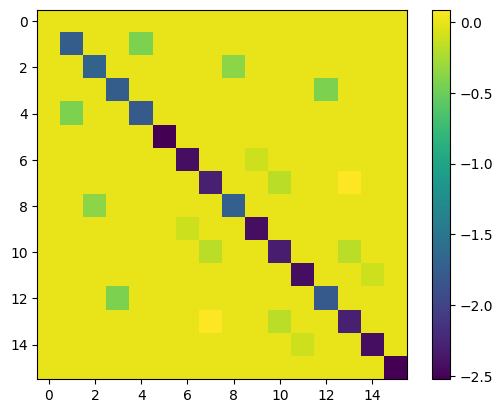

In [36]:

plt.imshow(np.real(R_secular[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

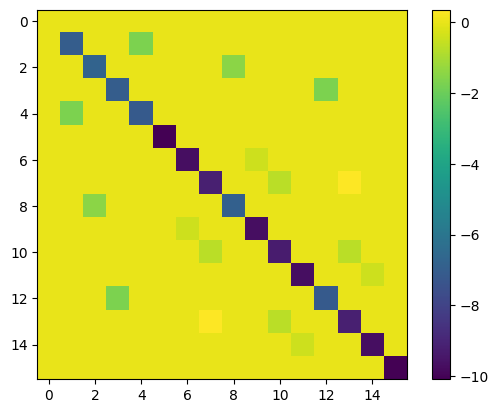

In [37]:
plt.imshow(np.real(R_sec_fromlist[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [36]:
np.linalg.norm(0.25*test_Rel_ala-R_secular)

33.135024347142505

34.19978962028727

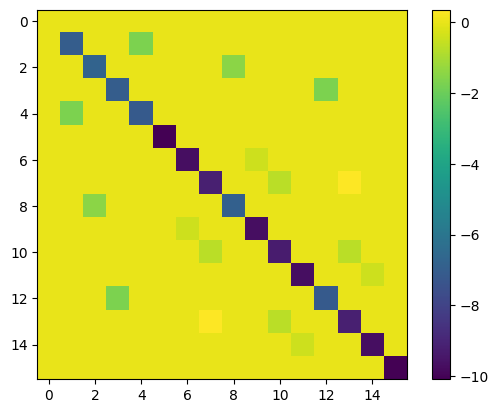

In [32]:
plt.imshow(np.real(test_Rel_ala[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

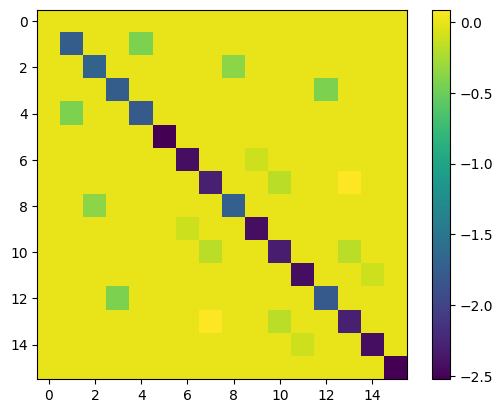

In [33]:
plt.imshow(np.real(R_secular[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [31]:
np.linalg.norm(test_Rel_ala-R_secular)

41.74111429009381

In [ ]:
loadMat = spio.loadmat('./data/NOESYdata_ALA_withGradients.mat',squeeze_me=True)

t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

R_secular = loadMat['p']['R'].item()
H_ala = loadMat['p']['H'].item().toarray()

rho0 = np.array(loadMat['p']['rho0'].item().toarray())

coil = np.array(loadMat['p']['coil'].item())

Lx = loadMat['p']['Lx'].item().toarray() 
Ly = loadMat['p']['Ly'].item().toarray() 

###Dynamical evolution for calculation of 2D spectra...
Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)



#Parameters taken from Spinach script
tmix = 1.0
dt1 = 0.25e-3
dt2 = 0.25e-3

##Parameters for Fourier transform
zerofill1 = 4096
zerofill2 = 4096


#Calculation of the NOESY spectra using the reference relaxation matrix and the Kite and the jump-operator-truncated approach

Ref_spec = GenNOESYSpectrum(H_ala,R_secular,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Approx_spec = GenNOESYSpectrum(H_ala,R_ala_approx,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Kite_spec = GenNOESYSpectrum(H_ala,R_refALAKite,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

Sec_An_spec = GenNOESYSpectrum(H_ala,R_ala_sec_an,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)